Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [1]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import activations

In [7]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [8]:
root_path = 'gdrive/My Drive/UpGrad/CNN_Assignment/'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/")
data_dir_test = pathlib.Path('gdrive/My Drive/UpGrad/CNN_Assignment/Test/')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, color_mode='rgb', batch_size=32, image_size=(180,180), seed=123, validation_split= 0.2, subset= 'training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, color_mode='rgb', batch_size=32, image_size=(180,180), seed=123, validation_split= 0.2, subset= 'validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

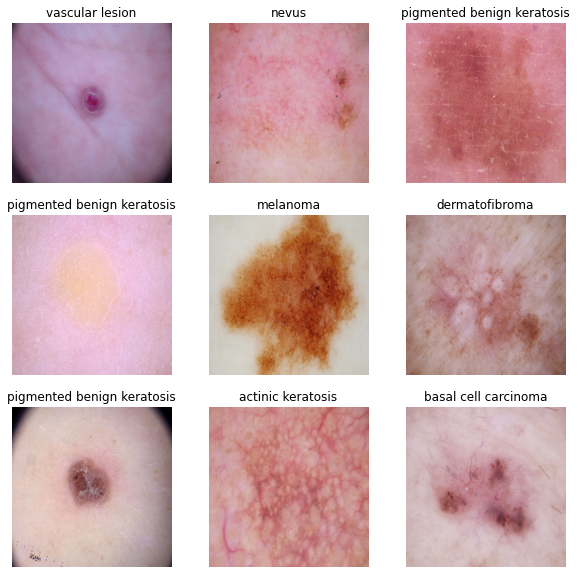

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04074622 1.0


In [24]:
num_classes = 9

In [25]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [26]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 181s 3s/step - loss: 2.2355 - accuracy: 0.1999 - val_loss: 1.9414 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.8201 - accuracy: 0.3290 - val_loss: 1.7789 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5513 - accuracy: 0.4653 - val_loss: 1.3582 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: 1.3171 - accuracy: 0.5495 - val_loss: 1.4060 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.2809 - accuracy: 0.5368 - val_loss: 1.4941 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.1585 - accuracy: 0.5895 - val_loss: 1.3631 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 1.0507 - accuracy: 0.6298 - val_loss: 1.4215 - val_accuracy: 0.5526
Epoch 8/20
56

### Visualizing training results

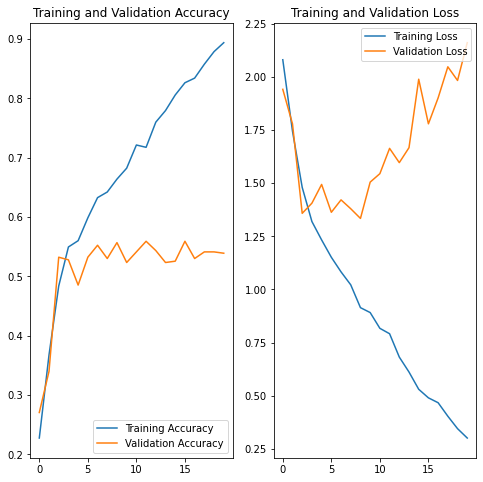

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# After I have analysed the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

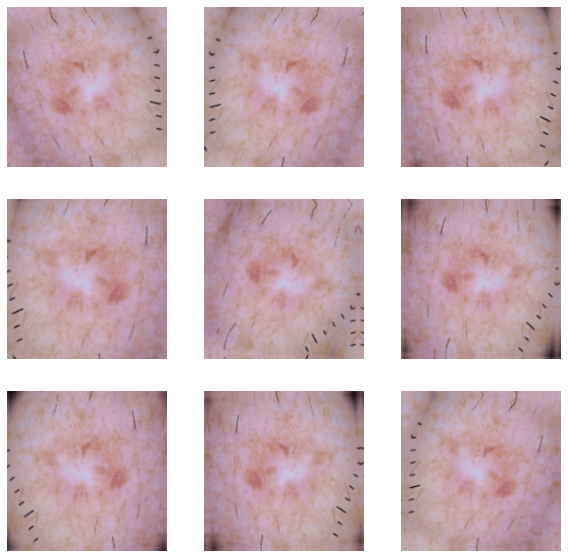

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Visualizing how my augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

## We are using a  Dropout layer as there is an evidence of overfitting in the above findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [33]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs
## Training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 54ms/step - loss: 2.1634 - accuracy: 0.1798 - val_loss: 1.8760 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8420 - accuracy: 0.3245 - val_loss: 1.7641 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6823 - accuracy: 0.3884 - val_loss: 1.5855 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5407 - accuracy: 0.4409 - val_loss: 1.4867 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4751 - accuracy: 0.4832 - val_loss: 1.3975 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3372 - accuracy: 0.5252 - val_loss: 1.4805 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3162 - accuracy: 0.5109 - val_loss: 1.4362 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing the results

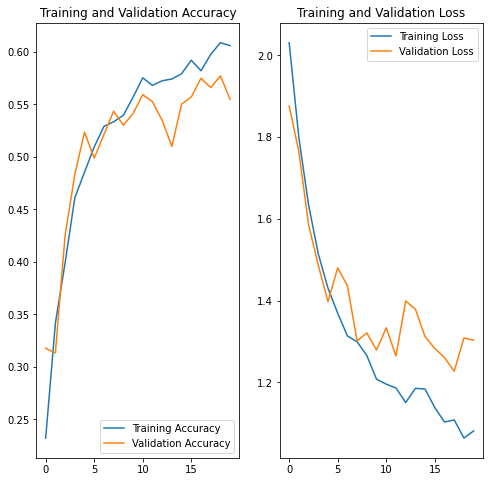

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
## Your code goes here.

from pathlib import Path

In [41]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/actinic keratosis")
print(data_dir_train)
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

gdrive/My Drive/UpGrad/CNN_Assignment/Train/actinic keratosis


114

In [42]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/basal cell carcinoma")
print(data_dir_train)
paths2 = Path(data_dir_train).glob('**/*.jpg')
bcc=len(list(paths2))
bcc

gdrive/My Drive/UpGrad/CNN_Assignment/Train/basal cell carcinoma


376

In [43]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/dermatofibroma")
print(data_dir_train)
paths3 = Path(data_dir_train).glob('**/*.jpg')
d=len(list(paths3))
d

gdrive/My Drive/UpGrad/CNN_Assignment/Train/dermatofibroma


95

In [44]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/melanoma")
print(data_dir_train)
paths4 = Path(data_dir_train).glob('**/*.jpg')
m=len(list(paths4))
m

gdrive/My Drive/UpGrad/CNN_Assignment/Train/melanoma


438

In [45]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/nevus")
print(data_dir_train)
paths5 = Path(data_dir_train).glob('**/*.jpg')
n=len(list(paths5))
n

gdrive/My Drive/UpGrad/CNN_Assignment/Train/nevus


357

In [46]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/pigmented benign keratosis")
print(data_dir_train)
paths6 = Path(data_dir_train).glob('**/*.jpg')
pbk=len(list(paths6))
pbk

gdrive/My Drive/UpGrad/CNN_Assignment/Train/pigmented benign keratosis


462

In [47]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/seborrheic keratosis")
print(data_dir_train)
paths7 = Path(data_dir_train).glob('**/*.jpg')
sk=len(list(paths7))
sk

gdrive/My Drive/UpGrad/CNN_Assignment/Train/seborrheic keratosis


77

In [48]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma")
print(data_dir_train)
paths8 = Path(data_dir_train).glob('**/*.jpg')
scc=len(list(paths8))
scc

gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma


181

In [49]:
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/CNN_Assignment/Train/vascular lesion")
print(data_dir_train)
paths9 = Path(data_dir_train).glob('**/*.jpg')
vl=len(list(paths9))
vl

gdrive/My Drive/UpGrad/CNN_Assignment/Train/vascular lesion


139

In [50]:
Total=ak+bcc+d+m+n+pbk+sk+scc+vl

In [51]:
hp=int(pbk/Total)
hp

0

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [52]:
!pip install Augmentor

In [53]:
path_to_training_dataset=os.getcwd()
path_to_training_dataset = path_to_training_dataset + "gdrive/My Drive/UpGrad/CNN_Assignment/Train"
print(path_to_training_dataset)

/contentgdrive/My Drive/UpGrad/CNN_Assignment/Train


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
import Augmentor

In [62]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1C74CF90>:   0%|          | 1/500 [00:00<01:00,  8.23 Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA7009BFD0>: 100%|██████████| 500/500 [00:21<00:00, 22.88 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA20AAF7D0>: 100%|██████████| 500/500 [00:22<00:00, 22.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA70066190>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBA700F9490>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBA20AB2A10>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA700D5CD0>: 100%|██████████| 500/500 [00:22<00:00, 22.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA20A97D50>: 100%|██████████| 500/500 [00:47<00:00, 10.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA20A5D850>: 100%|██████████| 500/500 [00:22<00:00, 21.83 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA20AAFC90>:   0%|          | 1/500 [00:00<00:50,  9.96 Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1C76BBD0>: 100%|██████████| 500/500 [00:21<00:00, 22.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [63]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [64]:
print(data_dir_train)

gdrive/My Drive/UpGrad/CNN_Assignment/Train


In [65]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [67]:
import glob

In [70]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026492.jpg_c58add1c-9e88-4fc4-96cb-7f0c9a884f64.jpg',
 'gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026522.jpg_028a295b-2dd6-4d2d-9c3b-598fbd97a43b.jpg',
 'gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027678.jpg_5da0dc06-b2d1-4e7c-85d4-6a4db313e10e.jpg',
 'gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027084.jpg_dea0d3c0-03c7-4f8d-a717-f999c80858e3.jpg',
 'gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027550.jpg_a65a77de-801a-4882-bcd9-ba0324d28621.jpg',
 'gdrive/My Drive/UpGrad/CNN_Assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030549.jpg_5dafc70c-f383-4691-97ad

In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [74]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [75]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [76]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [78]:
## your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.25 0.99967325


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [79]:
## your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [82]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 54s 306ms/step - loss: 2.1864 - accuracy: 0.1697 - val_loss: 1.6335 - val_accuracy: 0.4009
Epoch 2/30
169/169 [==============================] - 53s 302ms/step - loss: 1.5800 - accuracy: 0.4063 - val_loss: 1.3946 - val_accuracy: 0.4744
Epoch 3/30
169/169 [==============================] - 52s 298ms/step - loss: 1.3245 - accuracy: 0.5222 - val_loss: 1.2525 - val_accuracy: 0.5664
Epoch 4/30
169/169 [==============================] - 52s 297ms/step - loss: 1.1244 - accuracy: 0.5856 - val_loss: 1.1956 - val_accuracy: 0.5924
Epoch 5/30
169/169 [==============================] - 52s 298ms/step - loss: 0.9304 - accuracy: 0.6588 - val_loss: 1.0447 - val_accuracy: 0.6177
Epoch 6/30
169/169 [==============================] - 52s 300ms/step - loss: 0.8044 - accuracy: 0.7130 - val_loss: 0.9924 - val_accuracy: 0.6741
Epoch 7/30
169/169 [==============================] - 53s 303ms/step - loss: 0.6980 - accuracy: 0.7510 - val_loss: 0.9921 - val_ac

#### **Todo:**  Visualize the model results

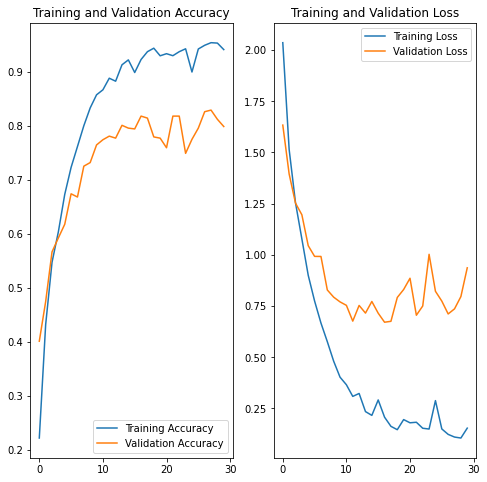

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

